Data 604 Final Project: Bicycle Shop Simulation

Leticia Salazar

July 17th, 2022

##### The problem and its significance. 

The bicycle industry has boomed within the last 2 years of a global pandemic. With bicycles, parts and accessories being scarces sales and repairs have been affected along with unusual wait times, delivery delays and more.

The following project simulates a 'typical' day at a bicycle shop, the services they provide and wait times pre-pandemic. 

Note: this does not include phone calls and emails from customers and focusing only on in person interactions:

* Customer Arrival
* Meet with person working the floor: Depending on the type of service needed the customer will be going into one of three different service areas:
    * Random inquiries: using air pump, questions not related to the business, browsing, etc
    * Sales: looking to buy a bicycle, parts or accessories
        * Special orders: if items are not available some customers may decided to place an order (can take up to 2 days for the order to arrive)
    * Repairs: within this category there's different types of services
        * Short repair: flat fixes, minor adjustments (these usually take anywhere between 10 - 45 minutes)
        * Long repairs: tune-ups, bike assemblies, part replacements, major adjustments (these usually take between 1 hour - 1 business days)
* Normal Exit

For the time being I will be combining Sales and Special orders to be a max time of 60 minutes, Repairs(long and short) to be combined for a max of 75 minutes. All assuming they make a normal exit since in real life, a bicycle shop's simulation would require more time and an additional category (Storage). I have provided a flow chart of what this would look like. I did attempt to make a simulation using the second flow-chart model but being fairly new using Python and SimPy I failed to make a functional model.

##### Flow-chart model.

The process is shown below diplaying the different options customers have upon arrival and first interaction with floor person.

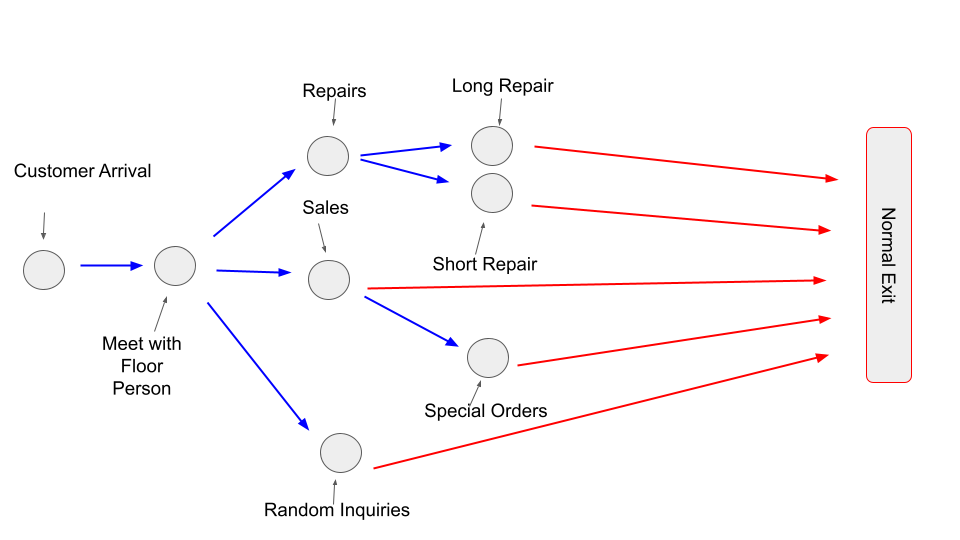

In [1]:
# Bicycle shop model modified and used for this simulation
from IPython.display import Image
Image(filename = '/Users/letiix3/Desktop/Data-604/Week_7/Sim_bike_shop.png', width = 600, height = 700)

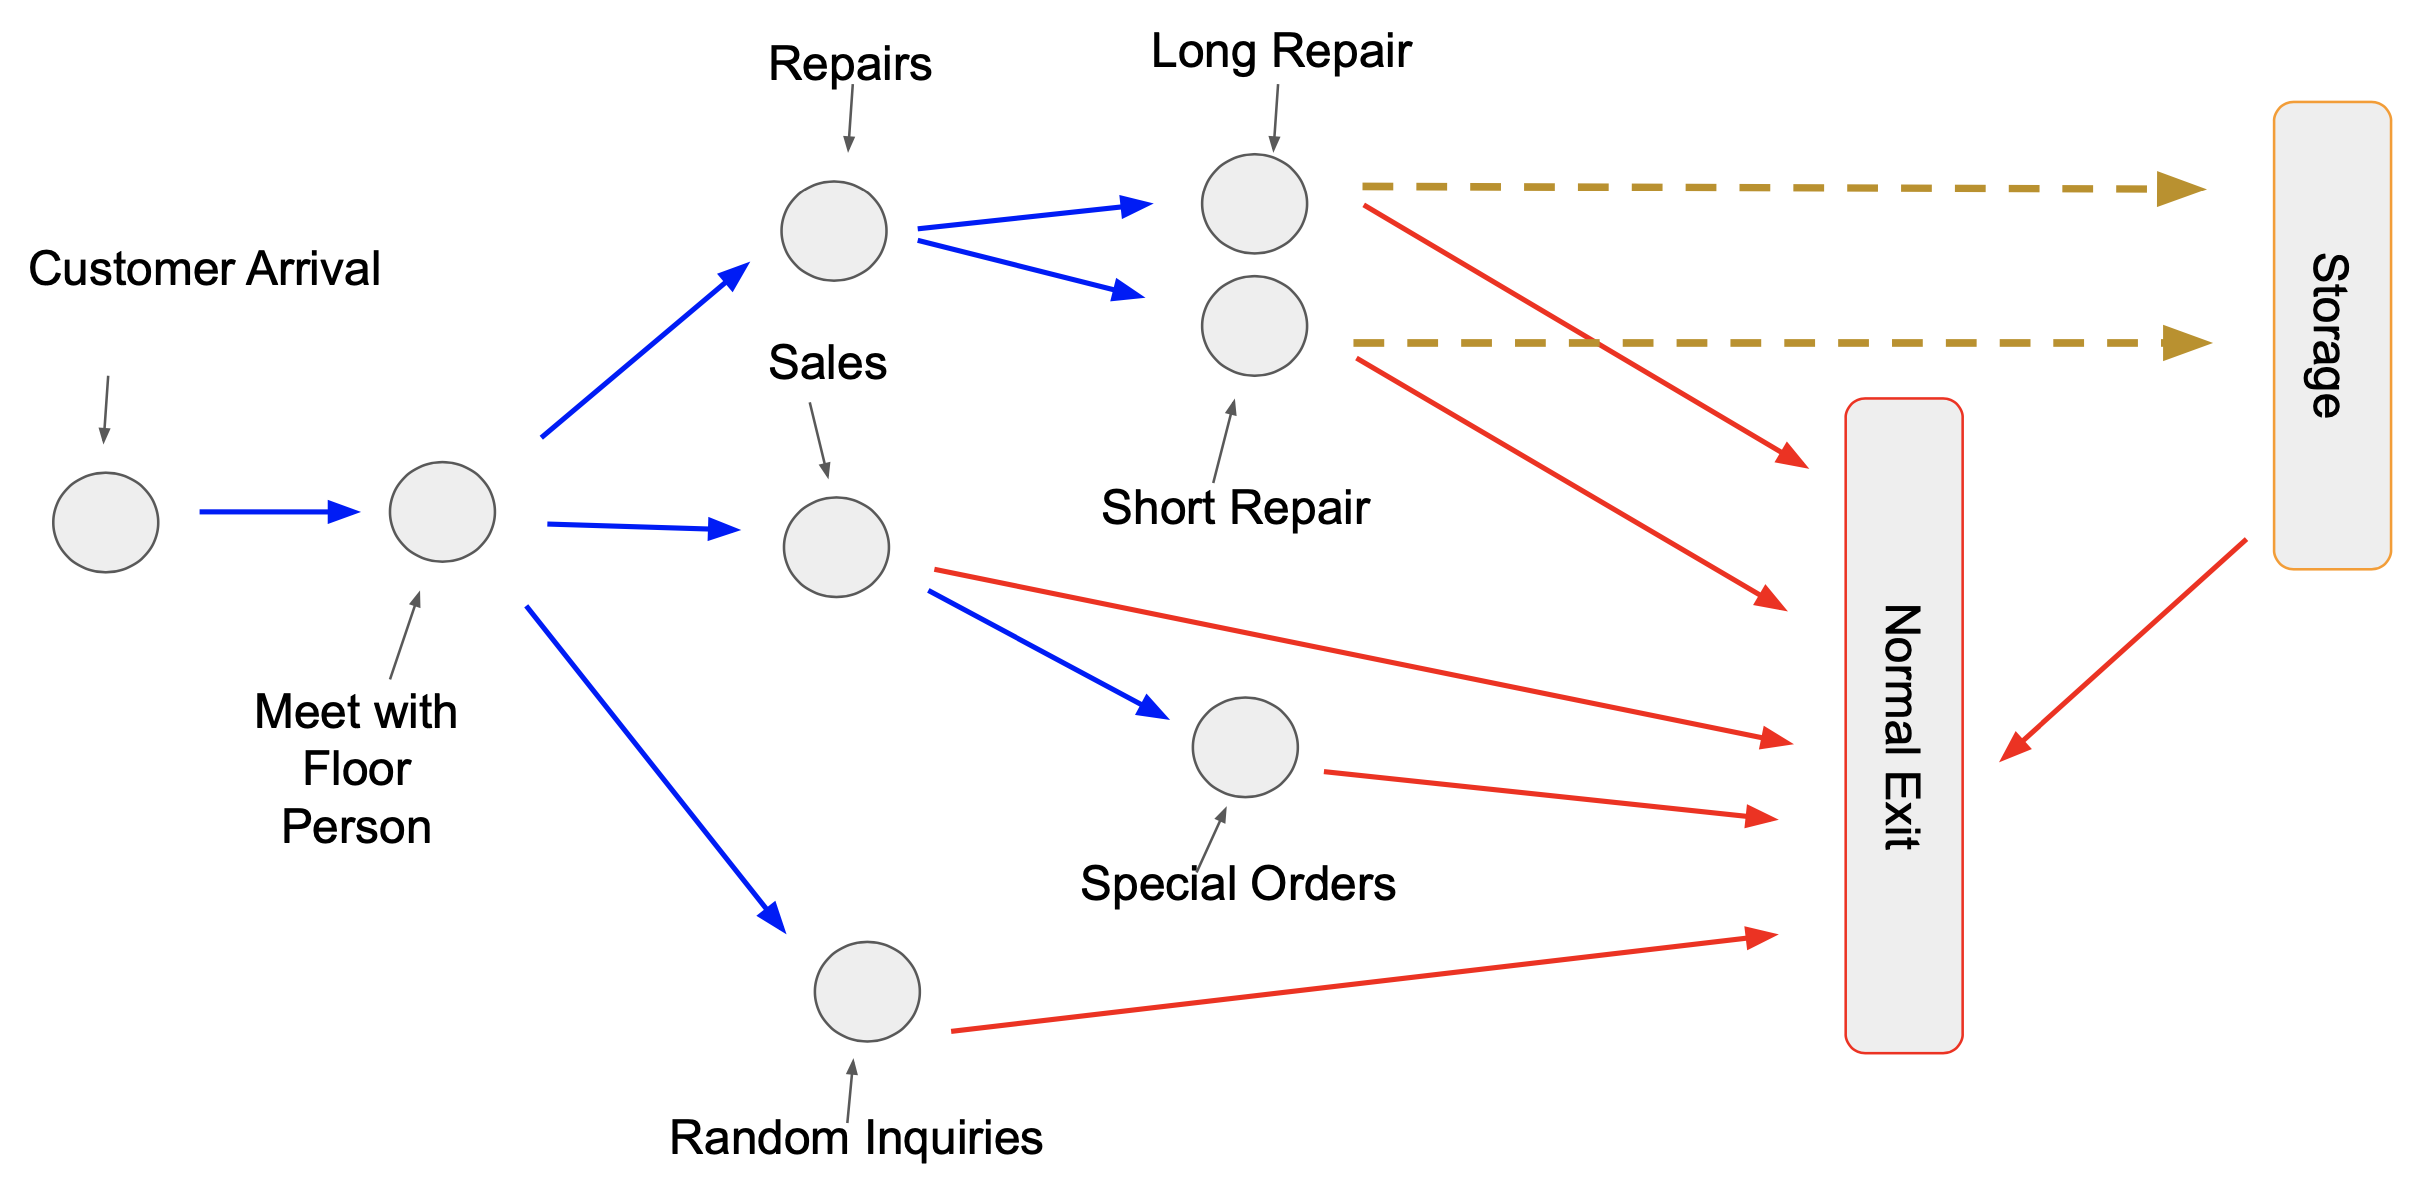

In [2]:
# Bicycle shop model initially intended to use
from IPython.display import Image
Image(filename = '/Users/letiix3/Desktop/Data-604/Week_7/bike_shop_sim.png', width = 600, height = 700)

In [3]:
# Required libraries
import simpy
import numpy as np
import pandas as pd
import random
from modsim import *
import matplotlib.pyplot as plt

In [4]:
# Setting seed and iterations
seed = 50
simulation_time = 8 # operational hours

In [5]:
np.random.seed(seed)

# Creating a data frame to later store data here
data = pd.DataFrame(columns = ['Customer Id', 'Service', 'Arrival Time', 'Floor Time', 'Service Start Time', 'Service Stop Time'])

In [6]:
# Setting customer arrival every 15 minutes from 2 - 5 customers
def customer_arrival():
    return np.random.exponential(10.0/np.random.randint(2,5))

# Setting time it takes for a customer to meet with floor person     
def meet_floor_person(self, customer):
    # min of 2 minutes and max of 10 minutes
    yield self.env.timeout(random.randint(2, 5))
    
# Setting time it takes for customer to be in repair station
def repair_service():
    return np.random.triangular(10,30,85)

# Setting time it takes for customer to be in sales station
def sales_service():
    return np.random.triangular(5,30,75)

# Setting time it takes for random inqiry to be completed
def random_service():
    return np.random.triangular(2,5,10)

In [7]:
# Defining customer's arrival time to bike shop
def bike_shop(env,  repair, sales, random):
    global current_hour
    
    # Counter for customer's
    i = 0 
    while True:
        Service = np.random.choice(['Repair', 'Sales', 'Random'], p=[0.80, 0.1, 0.1]) 
        i += 1
        yield env.timeout(customer_arrival())
        env.process(customer(env, i,  repair, sales, random, Service))

In [8]:
# Function to generate report for each customer
def customer(env, customer, repair, sales, random, Service):
    
    global data # global variable

    if Service == 'Sales':
        req = sales
    else:
        req = repair
    
    with sales.request() as request:
        arrival_time = env.now # starts the clock
        yield env.timeout(5) # Floor person generation time of 5 minutes
        floor_time = env.now # Records the time a floor person takes with a customer
        
        yield request
        
        # Service starts
        service_start_time = env.now
        
        if Service == 'Sales':
            yield env.timeout(sales_service())
        else:
            yield env.timeout(repair_service())
        service_stop_time = env.now 
        
        # Records the generated data
        row = pd.DataFrame([['Customer_{}'.format(customer), Service, arrival_time, floor_time, service_start_time, service_stop_time]],
                          columns = ['Customer Id', 'Service', 'Arrival Time', 'Floor Time','Service Start Time', 'Service Stop Time'])
       
        data = data.append(row, ignore_index = True, sort = False)
        
        # Calculate wait time
        data['Floor Time (Mins)'] = (data['Floor Time'] - data['Arrival Time'])
        data['Service Time (Mins)'] = (data['Service Stop Time'] - data['Service Start Time'])
        data['Wait Time (Mins)'] = (data['Service Start Time'] - data['Floor Time'] )


In [9]:
#Running model
def model(nruns, nrepair, nsales, nrandom): 
    
    # Initializing
    Repair=[] 
    Sales=[]
    Random=[]
    avg_wait_time = []
    sales_wait_time = []
    repair_wait_time = []
    random_wait_time = []
    global data
    for j in range(nruns):
        data = data[0:0]
        env = simpy.Environment()
        env.initial_time = 0
        
        # Assigning parameters as Resource
        repair = simpy.Resource(env, capacity=nrepair) 
        sales = simpy.Resource(env, capacity=nsales) 
        random = simpy.Resource(env, capacity=nrandom) 
        env.process(bike_shop(env, repair, sales, random))
        # Run for 8 ohours
        env.run(until = 8 * 60) 
        
        # Calculating means separately to use later on
        Sales=data[data.Service.isin(['Sales'])] 
        Repair=data[data.Service.isin(['Repair'])]
        Random=data[data.Service.isin(['Random'])]
    
        # Calculating average time
        avg_wait=data['Wait Time (Mins)'].mean() 
        avg_wait_repair=Repair['Wait Time (Mins)'].mean()
        avg_wait_sales=Sales['Wait Time (Mins)'].mean()
        avg_wait_random=Random['Wait Time (Mins)'].mean()
    
        avg_wait_time.append(avg_wait)
        sales_wait_time.append(avg_wait_sales)
        repair_wait_time.append(avg_wait_repair)
        random_wait_time.append(avg_wait_random)
        
    #Save dataframe
    new_dict = {"avg_wait": avg_wait_time, "sales_wait": sales_wait_time, "repair_wait": repair_wait_time, "random_wait": random_wait_time }
    
    global new_data
    new_data = pd.DataFrame(new_dict)
    return new_data

In [10]:
# Tesitng model and checking results
np.random.seed(55)
'''
Model shows 28 operational days with 20 repairs, 
14 sales, and 10 random inquiries
'''
model(28,20,14,12)

,avg_wait,sales_wait,repair_wait,random_wait
0,9.506942,8.184041,9.463690,11.013042
1,4.485140,2.443108,4.771528,3.998816
2,16.165311,14.553849,16.527069,15.967983
3,0.503270,0.714661,0.540376,0.152540
4,2.528511,1.088822,2.755468,1.884009
5,2.231701,2.749884,2.068974,2.697221
6,0.086868,0.000000,0.114799,0.048331
7,2.568608,1.902669,2.765083,1.308628
8,1.808862,1.200027,1.851202,1.851302
9,0.462807,0.547283,0.468719,0.358962


##### Justify the validity of the model and discuss how you verified it

The model was verified by trial and error, every time I adjusted the model and ran the simulation I would adjust the numbers in the model() to ensure I was getting good estimates on the waiting times for each service. After many attempts, the output model(28,20,14,10) (28 days, 20 repairs, 14 sales and 10 random inquiries) showed a good descriptor of wait times to get a service in a bike shop. To confirm the validity of this simulation is hard, since I do not know of other models out there for bike shops. Again, based on trial and error I was abe to find wait times close enough to reality (basing on my personal experience).

Below I show the data frame with multiple iterations of randomized services performed throughout the 8 hours of operation to show how the simulation performed.

In [11]:
# Showing full data frame
data

,Customer Id,Service,Arrival Time,Floor Time,Service Start Time,Service Stop Time,Floor Time (Mins),Service Time (Mins),Wait Time (Mins)
0,Customer_2,Sales,4.021719,9.021719,9.021719,41.442046,5.0,32.420328,0.0
1,Customer_4,Repair,5.769208,10.769208,10.769208,43.781207,5.0,33.011999,0.0
2,Customer_1,Repair,0.003581,5.003581,5.003581,46.179187,5.0,41.175606,0.0
3,Customer_5,Random,5.773898,10.773898,10.773898,48.104902,5.0,37.331003,0.0
4,Customer_6,Random,25.123650,30.123650,30.123650,57.958757,5.0,27.835107,0.0
...,...,...,...,...,...,...,...,...,...
95,Customer_102,Repair,430.349953,435.349953,435.349953,451.759922,5.0,16.409969,0.0
96,Customer_97,Repair,404.075556,409.075556,409.075556,460.310999,5.0,51.235443,0.0
97,Customer_95,Repair,401.514067,406.514067,406.514067,461.445066,5.0,54.930999,0.0
98,Customer_105,Repair,439.404091,444.404091,444.404091,465.792088,5.0,21.387997,0.0


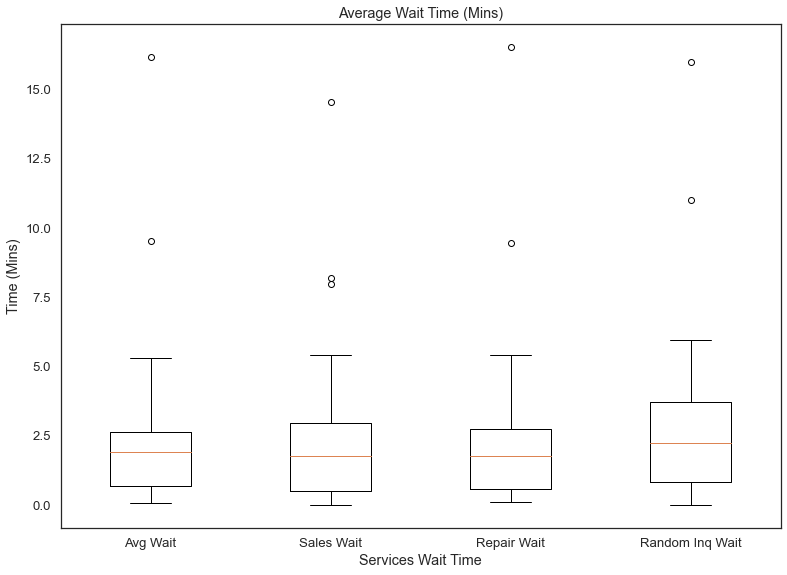

In [12]:
# Boxplot of new_data 
fig = plt.figure(figsize = (10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot and labeling axis
plt.boxplot(new_data)
plt.title('Average Wait Time (Mins)')
plt.ylabel('Time (Mins)')
plt.xlabel('Services Wait Time')
plt.xticks([1,2,3,4], ['Avg Wait', 'Sales Wait', 'Repair Wait', 'Random Inq Wait'])

# show plot
plt.show()


##### Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues. Post this to the discussion. 

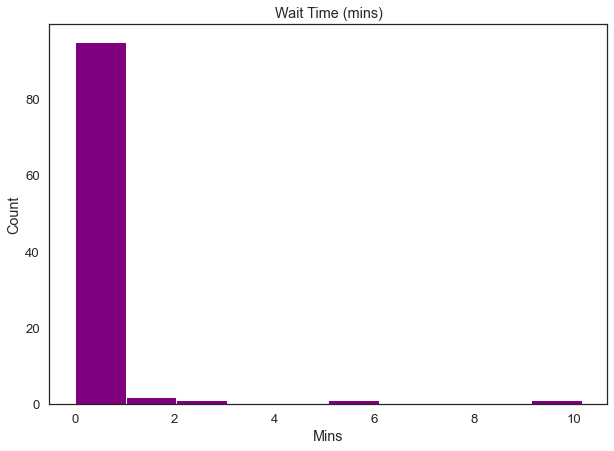

In [13]:
# Histogram of wait time in minutes
fig = plt.figure(figsize = (10,7))
plt.hist(data['Wait Time (Mins)'], color = 'purple')
plt.title('Wait Time (mins)')
plt.xlabel('Mins')
plt.ylabel('Count')
plt.show()

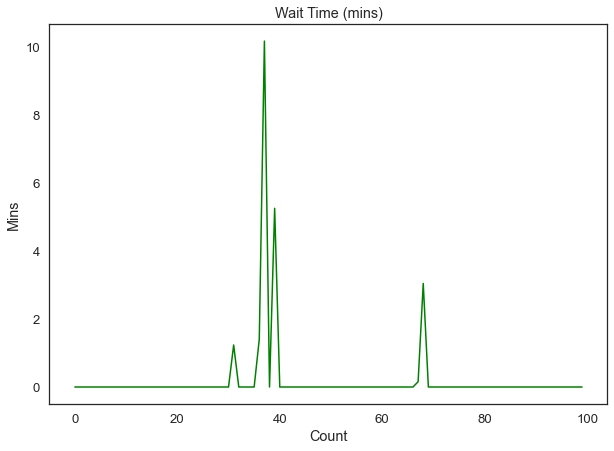

In [14]:
# Line plot of wait times in minutes
fig = plt.figure(figsize = (10,7))
plt.plot(data['Wait Time (Mins)'], color = 'green')
plt.title('Wait Time (mins)')
plt.ylabel('Mins')
plt.xlabel('Count')
plt.show()

<AxesSubplot:>

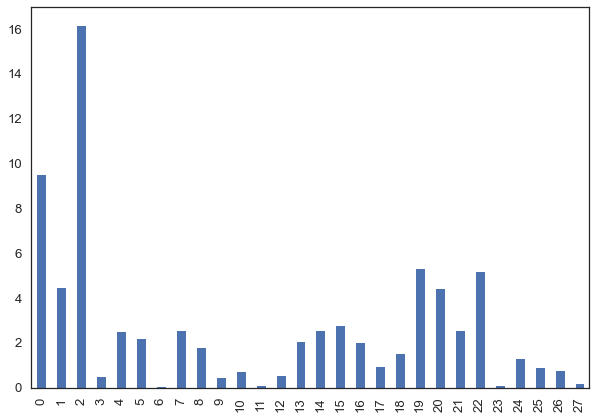

In [15]:
# More interesting is the avg wait time during the month

new_data['avg_wait'].plot.bar(figsize = (10,7))

#Out of 22 days, average wait time exceeded 10 mins on 2 days. This is less than 10% of the time.

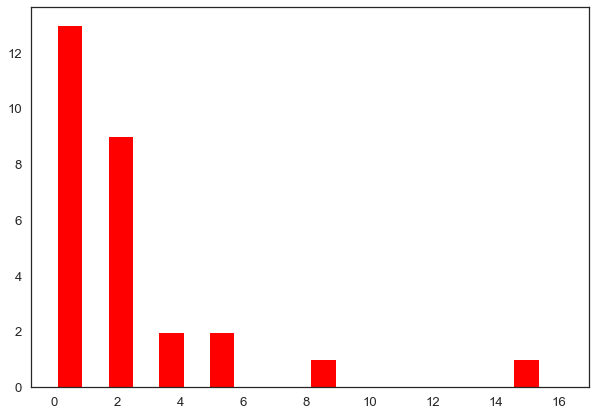

In [16]:
# Histogram plot
fig = plt.figure(figsize = (10,7))

plt.hist(new_data['avg_wait'], width = 0.8, color = 'red')

plt.show()

##### State  your conclusions/ findings from the model. 

Based on my model I conclude that the average wait time to get a service is less than 1 minute. Majority of the customers that come in to the shop wait no more than 4 minutes to get a service with a few waiting 8 minutes or more.

My model also showed some missing values for wait times for random inquiries which I found odd but looking back at my code I realized I removed the random_service out from the for loop because I kept getting errors. The errors coud have been because I wasn't placing the random inquiries properly in the for loop.

In [17]:
# Print out the Averages calculated

print('Avg wait:', data['Wait Time (Mins)'].mean())

Sales = data[data.Service.isin(['Sales'])]
print('Avg time for a customer going for sales to wait is:',Sales['Wait Time (Mins)'].mean())

Repair = data[data.Service.isin(['Repair'])]
print('Avg time for a customer going for repair to wait is:',Repair['Wait Time (Mins)'].mean())

Random = data[data.Service.isin(['Random'])]
print('Avg time for a customer going for random inqury to wait is:',Random['Wait Time (Mins)'].mean())

Avg wait: 0.21256624920468653
Avg time for a customer going for sales to wait is: 0.37520058794533134
Avg time for a customer going for repair to wait is: 0.20801885725433988
Avg time for a customer going for random inqury to wait is: 0.08229852161172554
